In [454]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

In [455]:
torch.manual_seed(0)

In [456]:
if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")  # Use GPU for computations
else:
    print("GPU is not available. Using CPU.")
    device = torch.device("cpu")  # Use CPU for computations

GPU is available!


Get the dataset

In [457]:
# Define transformations for data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [458]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [459]:
train_dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

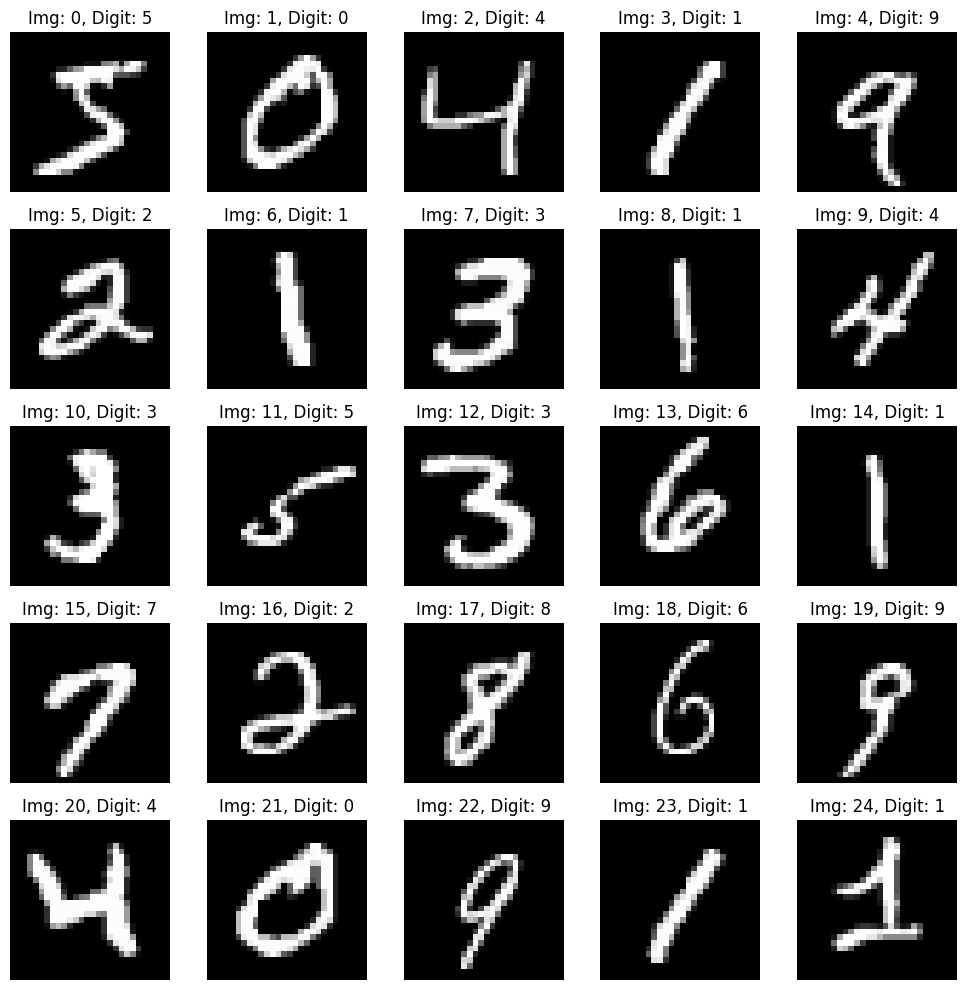

In [460]:
# Get a sample of images
images = train_dataset.data[:25]  # Get the first 25 images

# Create a grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Plot the images with their corresponding labels
for i, image in enumerate(images):
    # Squeeze to remove unnecessary dimension for plotting
    image = image.squeeze()
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    axes[i // 5, i % 5].set_title("Img: {}, Digit: {}".format(i, int(train_dataset.targets[i])))
    axes[i // 5, i % 5].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [461]:
batch_size = 1024

In [462]:
# Define training and testing data loaders (modify batch_size as needed)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [463]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers

        # We use input chnnale 1 because we have grayscale images, not RGB (3 channels)
        # Out channels: how many features / channels the output will be
        # Kenrle is 3x3 kernel

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            )
        )

        # fully connected layer, output 10 classes
        self.linear = nn.Linear(
            in_features=6272, 
            out_features=10
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2
        x = x.view(x.size(0), -1)
        output = self.linear(x)
        return output, x    # return x for visualization


In [464]:
# Define model, loss function, and optimizer
model = CNN()

# Run as cuda
torch.set_default_device('cuda')
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


print(model)
print(optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (linear): Linear(in_features=6272, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


Train the model

In [465]:
# Train the model
num_epochs = 5

# Store losses and accuracy for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Enumerate on batch
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        
        # Forward pass
        outputs, x = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store loss for plotting
        train_losses.append(loss.item())

        # Print training stats (modify as needed)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate accuracy (train)
        _, predicted = torch.max(outputs.data, 1)
        train_correct = (predicted == labels).sum().item()
        train_accuracy = 100 * train_correct / len(labels)
        train_accuracies.append(train_accuracy)


    # Calculate test loss and accuracy after each epoch
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.cuda()
            test_labels = test_labels.cuda()
            test_outputs, _ = model(test_images)
            test_loss += criterion(test_outputs, test_labels).item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

    # Append test loss and accuracy
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%')

Epoch [1/5], Step [1/59], Loss: 2.3000
Epoch [1/5] Train Loss: 0.3362, Test Loss: 0.2789, Train Acc: 91.28%, Test Acc: 91.68%
Epoch [2/5], Step [1/59], Loss: 0.3098
Epoch [2/5] Train Loss: 0.1519, Test Loss: 0.1551, Train Acc: 95.39%, Test Acc: 95.28%
Epoch [3/5], Step [1/59], Loss: 0.1653
Epoch [3/5] Train Loss: 0.1174, Test Loss: 0.0977, Train Acc: 96.38%, Test Acc: 97.17%
Epoch [4/5], Step [1/59], Loss: 0.1151
Epoch [4/5] Train Loss: 0.1250, Test Loss: 0.0776, Train Acc: 97.20%, Test Acc: 97.69%
Epoch [5/5], Step [1/59], Loss: 0.0967
Epoch [5/5] Train Loss: 0.0561, Test Loss: 0.0670, Train Acc: 98.03%, Test Acc: 97.87%


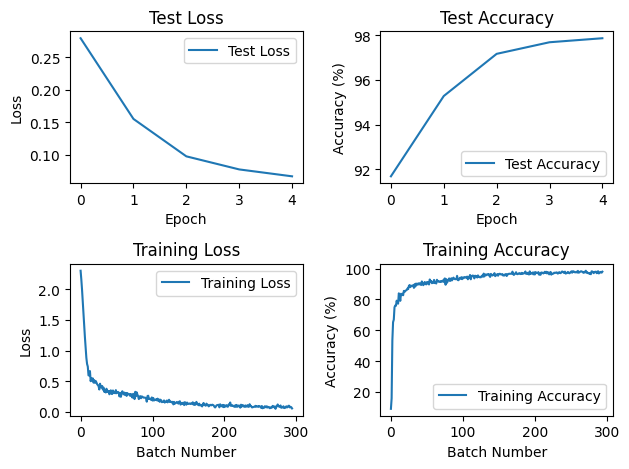

In [470]:
# Test Loss (plot 1)
plt.subplot(2, 2, 1)  # Row 1, Column 1
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Test Accuracy (plot 2)
plt.subplot(2, 2, 2)  # Row 1, Column 2
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

# Training Loss (plot 3)
plt.subplot(2, 2, 3)  # Row 2, Column 1
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Training Accuracy (plot 4)
plt.subplot(2, 2, 4)  # Row 2, Column 2
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [467]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 97.87%


Plot some images and their predictions

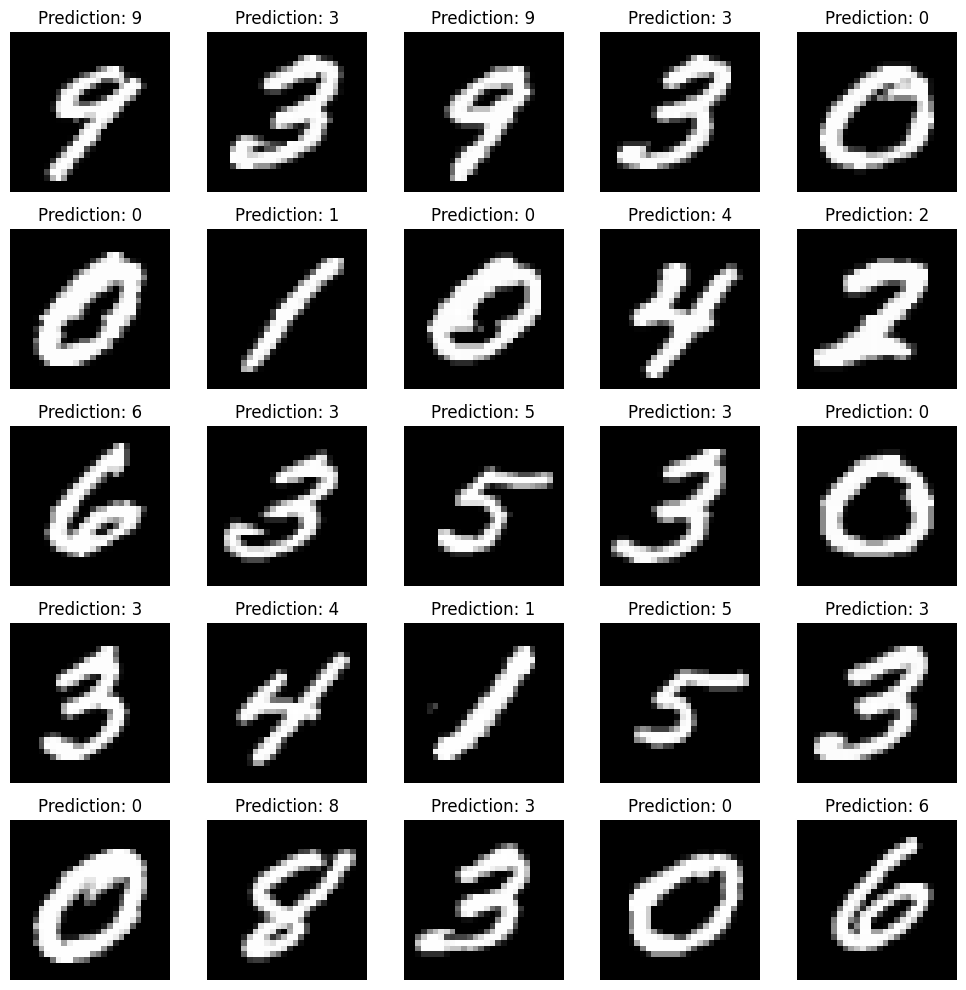

In [468]:
# Create a grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

with torch.no_grad():
    # Get first batch
    for test_images, _ in test_loader:
        outputs, _ = model(test_images.cuda())
        _, predicted = torch.max(outputs.data, 1)

        for i in range(25):
            image = test_images[i].cpu()
            axes[i // 5, i % 5].imshow(image.squeeze(), cmap='gray')
            axes[i // 5, i % 5].set_title("Prediction: {}".format(int(predicted[i].item())))
            axes[i // 5, i % 5].axis('off')


# Show the plot
plt.tight_layout()
plt.show()

Plot incorrectly labeled / predicted images by the model and plot

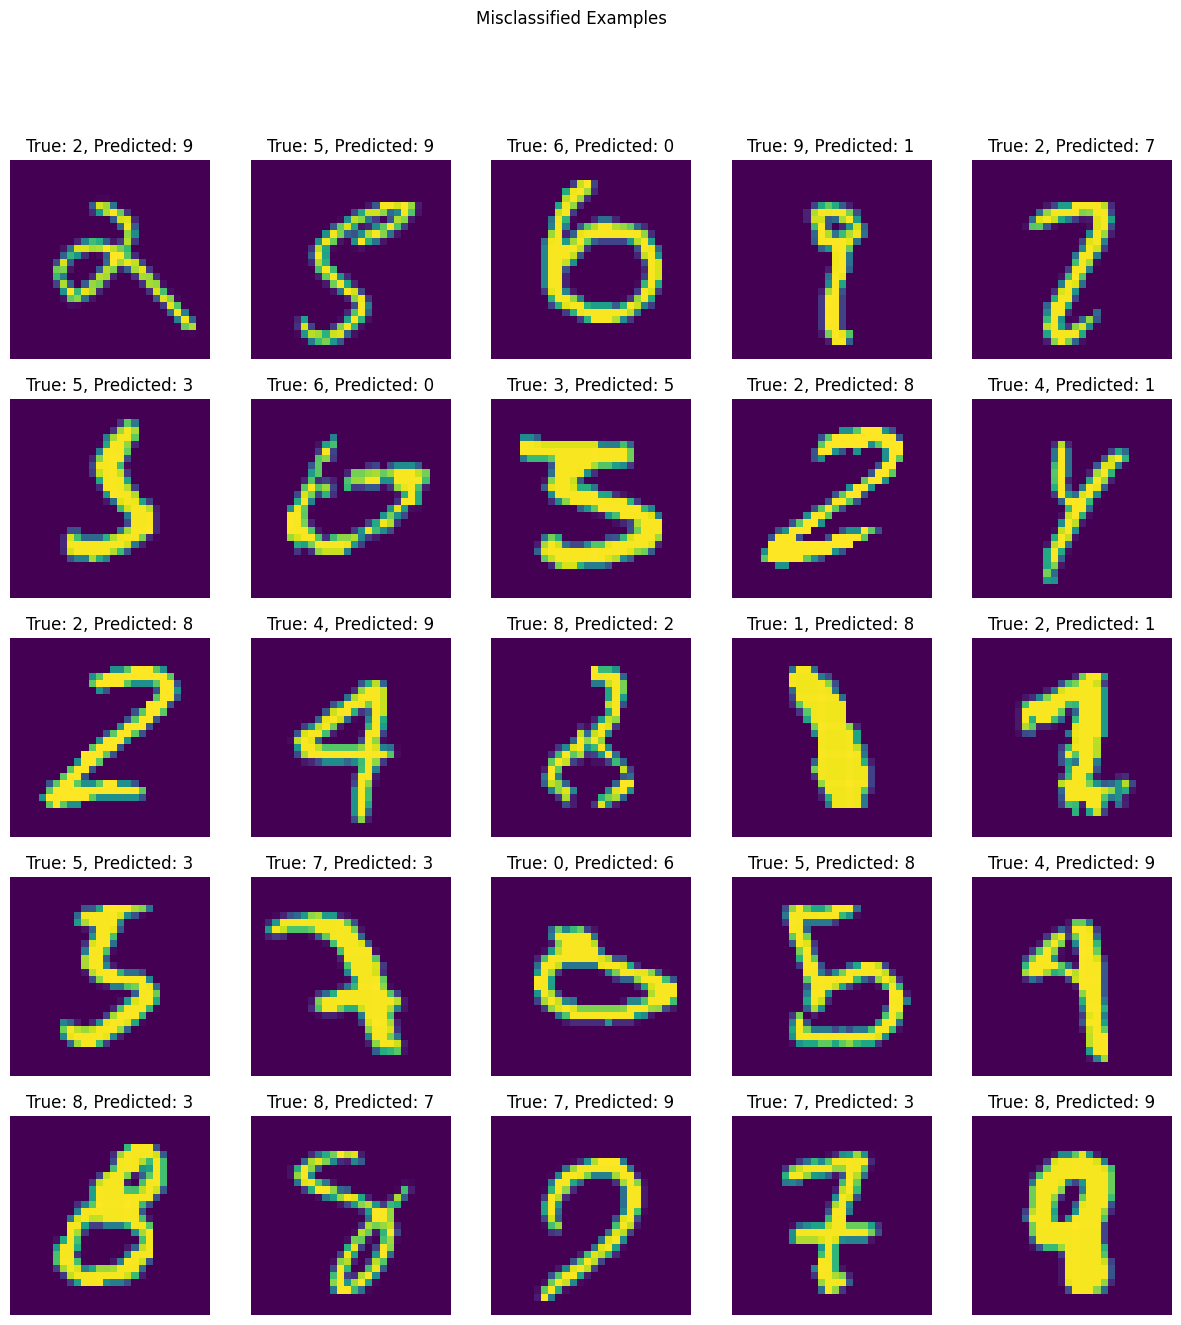

In [472]:
# Function to plot misclassified images
def plot_misclassified(images, labels, predicted):
    misclassified_indices = (predicted != labels).nonzero()  # Get indices of misclassified images
    misclassified_indices = misclassified_indices.cpu()
    misclassified_images = images[misclassified_indices].squeeze(1)  # Extract misclassified images

    # Assuming misclassified_images is a 4D tensor (batch, channels, height, width)
    num_images = 25
    rows, cols = 5, 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Create subplots

    for i, image in enumerate(misclassified_images[:num_images]):
        true_label = labels[misclassified_indices[i][0]].item()
        pred_label = predicted[misclassified_indices[i][0]].item()
        axes[i // 5, i % 5].imshow(image.squeeze())
        axes[i // 5, i % 5].set_title(f"True: {true_label}, Predicted: {pred_label}")
        axes[i // 5, i % 5].axis('off')

    fig.suptitle(f"Misclassified Examples", fontsize=12)

    plt.show()

# Test the model and get predictions
all_images = []
all_labels = []
all_predicted = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()  # Assuming your model uses CUDA
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_images.append(images.cpu())  # Collect all test images
        all_labels.append(labels)
        all_predicted.append(predicted)

# Concatenate tensors for easier processing
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_predicted = torch.cat(all_predicted, dim=0)

# Plot misclassified images
plot_misclassified(all_images, all_labels, all_predicted)